In [1]:
import numpy as np
from qiskit import *
import random
import time
from numpy import log as ln
import warnings
warnings.filterwarnings('ignore', module = 'qiskit')
# warnings.filterwarnings(action='once')

from qiskit.algorithms.optimizers import ADAM, AQGD, COBYLA, SPSA, TNC, CG, L_BFGS_B, GSLS, NELDER_MEAD, NFT, P_BFGS, POWELL, SLSQP
from qiskit.opflow.gradients import Gradient, NaturalGradient, QFI
from qiskit.opflow import CircuitStateFn, StateFn, I, X, Y, Z, H, CX, Zero, One, OperatorBase

from itertools import combinations as cm

In [2]:
# Generate Primes as an array
primes = [2,3,5]#,7,11,17,19,,31,37]
primes = primes[::-1]

combinations = list(cm(range(len(primes)), 2))

In [3]:
def generate_ZZcircuit(params, primes, assigned=True):
    cir = QuantumCircuit(len(primes))
    layers = int(len(params)/((2 * len(primes)) + len(combinations)))
    thetas = [qiskit.circuit.Parameter(str(i)) for i in range(layers * ((2 * len(primes)) + len(combinations)))]
    thetas_reshape = np.reshape(np.asarray(thetas),(layers, ((2 * len(primes)) + len(combinations))))
    params = np.reshape(np.asarray(params),(layers, ((2 * len(primes)) + len(combinations))))
    combs = list(cm(range(len(primes)), 2))
#     cir.h(range(len(primes)))
    
    for m in range(layers):
        l = len(params[m])
        g = thetas_reshape[m][0: len(primes)]
#         g_prime = [ln(2)*ln(30), ln(3)*ln(30),ln(5)*ln(30)]
        a = thetas_reshape[m][len(primes): (len(primes) + len(combs))]
#         a_prime = [ln(2)*ln(3), ln(2)*ln(5), ln(3)*ln(5)]
        b = thetas_reshape[m][(len(primes) + len(combs)) : l]
        
        for h in range(len(primes)):
            cir.rz(g[h], h)
        
        i = 0
        for j, k in combs:
            cir.rzz(a[i], j, k)
            i += 1
        for l in range(len(primes)):
            cir.rx(b[l], l)
            
    if assigned == True:
        thetas_reshape = thetas_reshape.flatten()
        params = params.flatten()
        p_dict = {thetas_reshape[i] : params[i] for i in range(len(thetas))}
        cir.assign_parameters(p_dict, inplace=True)
    cir.measure_all()
    
    return cir, thetas

[1.763188761944194, 0.09517682768191563, 2.7520190177206465, 2.8692540396503867, 2.0206304290737127, 1.671233029885608, 2.3260167571745782, 1.575743160401734, 0.5082112513156108]


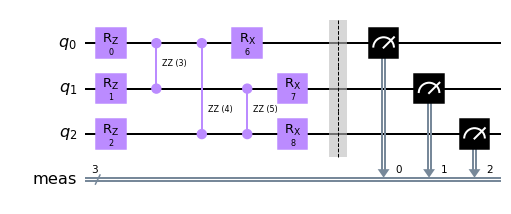

In [4]:
hyperparam = [random.uniform(0,np.pi) for _ in range(1 * ((2 * len(primes)) + len(combinations)))]
print(hyperparam)
cir, free_params = generate_ZZcircuit(hyperparam, primes, assigned=False)
cir.draw('mpl')

In [5]:
def obj_function(counts, n, penalty):
    max_c = 0
    max_bit = ""
    for c in counts:
        if counts[c] >= max_c:
            max_c =  counts[c]
            max_bit = c
    comp_primes = 1
    for i in range(len(max_bit)):
        comp_primes *= primes[i]**int(max_bit[i])
    p = 0
    if penalty == 1:
        if abs(comp_primes-n) > n:
            p += comp_primes**2 
#         return (n - comp_primes)**2
#     print(comp_primes, n-comp_primes, p)
    return (n - comp_primes) + p

In [6]:
def gen_f(n):
    
    def f(theta):
        qc, free_params = generate_ZZcircuit(theta, primes)
        back = Aer.get_backend('aer_simulator')
        back.set_options(device='GPU')
        job_sim = execute(qc, backend = back, shots = 2048).result()
        counts = job_sim.get_counts(qc)
        
        return obj_function(counts, n, 0)

    return f

In [7]:
def X_generator(primes, identity):
    #Generate X value for hamiltonian
    constant = 0

    for i in range(len(primes)):
        #Build Constant value iteratively
        constant += ln(primes[i])
        
        if i == 0:
            z_value = Z
        else:
            z_value = I
        #Build rest of X
        for j in range(1, len(primes)):
            if j == i:
                z_value = z_value ^ Z
            else:
                z_value = z_value ^ I
        if i == 0:
            x = -ln(primes[i]) * z_value
        else:
            x -= ln(primes[i]) * z_value
    #Combine Both to form X
    x += constant * identity
    
    return x

def hamiltonian(n, primes):
    #Generate Hamitonian according to number of primes
    identity = I
    
    for i in range(len(primes) - 1):
        identity = identity ^ I
        
    x = X_generator(primes, identity)
    
    lnn = float(ln(n))
    
    h = ((lnn**2) * identity) - (lnn * x) + (1 / 4 * (x ** 2))
    
    return h

In [8]:
h_value = hamiltonian(5, primes)
print(h_value.to_matrix())

[[ 2.59029039e+00+0.j  0.00000000e+00+0.j  0.00000000e+00+0.j
   0.00000000e+00+0.j  0.00000000e+00+0.j  0.00000000e+00+0.j
   0.00000000e+00+0.j  0.00000000e+00+0.j]
 [ 0.00000000e+00+0.j  8.39588705e-01+0.j  0.00000000e+00+0.j
   0.00000000e+00+0.j  0.00000000e+00+0.j  0.00000000e+00+0.j
   0.00000000e+00+0.j  0.00000000e+00+0.j]
 [ 0.00000000e+00+0.j  0.00000000e+00+0.j  2.60942818e-01+0.j
   0.00000000e+00+0.j  0.00000000e+00+0.j  0.00000000e+00+0.j
   0.00000000e+00+0.j  0.00000000e+00+0.j]
 [ 0.00000000e+00+0.j  0.00000000e+00+0.j  0.00000000e+00+0.j
   3.32411501e-02+0.j  0.00000000e+00+0.j  0.00000000e+00+0.j
   0.00000000e+00+0.j  0.00000000e+00+0.j]
 [ 0.00000000e+00+0.j  0.00000000e+00+0.j  0.00000000e+00+0.j
   0.00000000e+00+0.j -4.44089210e-16+0.j  0.00000000e+00+0.j
   0.00000000e+00+0.j  0.00000000e+00+0.j]
 [ 0.00000000e+00+0.j  0.00000000e+00+0.j  0.00000000e+00+0.j
   0.00000000e+00+0.j  0.00000000e+00+0.j  4.80453014e-01+0.j
   0.00000000e+00+0.j  0.00000000e+00+0.j

In [9]:
 def _convert_to_gradient_function(gradient_object, layers, n):

        def gradient_function(current_point):

            cir, free_params = generate_ZZcircuit(current_point, primes, assigned=False)
            cir.remove_final_measurements()
            c = hamiltonian(n, primes)
            op = ~StateFn(c) @ CircuitStateFn(primitive=cir, coeff=1.)
            grad_object = gradient_object.convert(operator=op, params=free_params)
            value_dict = {free_params[i]: current_point[i] for i in range(len(free_params))}
            x = grad_object.assign_parameters(value_dict).eval()
#             print(x)
#             analytical_gradients = np.array(x)# Change this part
            return np.real(x)
        
        return gradient_function

In [10]:
def run(optimizer, layers, func, gradient_function, n):
    g_f = _convert_to_gradient_function(gradient_function, layers, n)
    theta = [random.uniform(0, 2 * np.pi) for _ in range(layers * ((2 * len(primes)) + len(combinations)))]
    theta, loss, _ = optimizer.optimize(
                num_vars=len(theta),
                objective_function=func,
                initial_point=theta,
                gradient_function=g_f
                )
    return loss

gradient_types = ['param_shift'] #['', 'param_shift', 'lin_comb', 'fin_diff']
op_types = [AQGD(maxiter = 100)]#ADAM(maxiter = 100), momentum=0.02)]#, COBYLA(maxiter = 100), TNC(maxiter = 100), CG(maxiter = 100), GSLS(maxiter = 100), NELDER_MEAD(maxiter = 100)]#, NFT(maxiter = 500)]#, P_BFGS(maxfun = 500), POWELL(maxiter = 500), SLSQP(maxiter = 500)]
loss_list = []


for i in range(2, 16):
    print("Current n = ", i)
    fun = gen_f(i)
    n_list = []
    for j in range(1, 2):
        print("Current layer = ", j)
        layer_list = []
        for k in range(len(op_types)):
            print("Current opt = ", k)
            opt = op_types[k]
            grad_list = []
            for g in range(len(gradient_types)):
                print("Current Gradient = ", gradient_types[g] )
#                 if g == 0:
#                     grad = Gradient()
#                 else:
                grad = Gradient(grad_method=gradient_types[g])
                samples = []
                for _ in range(10):
                    start = time.perf_counter()
                    loss = run(opt,  j, fun, grad, i)
                    end = time.perf_counter()
                    samples.append((loss, end - start))
                grad_list.append(samples)
            layer_list.append(grad_list)
        n_list.append(layer_list)
    loss_list.append(n_list)

Current n =  2
Current layer =  1
Current opt =  0
Current Gradient =  param_shift
Current n =  3
Current layer =  1
Current opt =  0
Current Gradient =  param_shift
Current n =  4
Current layer =  1
Current opt =  0
Current Gradient =  param_shift
Current n =  5
Current layer =  1
Current opt =  0
Current Gradient =  param_shift
Current n =  6
Current layer =  1
Current opt =  0
Current Gradient =  param_shift
Current n =  7
Current layer =  1
Current opt =  0
Current Gradient =  param_shift
Current n =  8
Current layer =  1
Current opt =  0
Current Gradient =  param_shift
Current n =  9
Current layer =  1
Current opt =  0
Current Gradient =  param_shift
Current n =  10
Current layer =  1
Current opt =  0
Current Gradient =  param_shift
Current n =  11
Current layer =  1
Current opt =  0
Current Gradient =  param_shift
Current n =  12
Current layer =  1
Current opt =  0
Current Gradient =  param_shift
Current n =  13
Current layer =  1
Current opt =  0
Current Gradient =  param_shift


In [11]:
print(loss_list)

[[[[[(0, 18.221911698987242), (0, 18.23148695001146), (0, 24.558604922000086), (0, 18.64749317499809), (1, 32.02067318800255), (1, 26.054012194974348), (-1, 18.985985591018107), (0, 18.70176820200868), (-3, 18.500007813010598), (0, 20.794008436991135)]]]], [[[[(1, 33.81765977400937), (0, 23.2745122310007), (1, 21.953755908005405), (1, 23.528058822994353), (1, 26.557440634991508), (-2, 20.189944468002068), (1, 20.697935466014314), (1, 22.544630732008955), (-2, 19.451572374993702), (-2, 24.59525013898383)]]]], [[[[(-1, 20.588868038001237), (-1, 20.68096319201868), (-2, 20.514028012985364), (-2, 18.97762080701068), (1, 18.89170407698839), (1, 25.62795088600251), (-1, 20.708798243984347), (-1, 18.86919350401149), (-1, 31.404222065990325), (-2, 29.251732490985887)]]]], [[[[(2, 19.01952269699541), (0, 22.362394691997906), (0, 20.596119255002122), (-1, 18.973377955000615), (-5, 20.81781321199378), (-1, 24.188211881002644), (-5, 33.764404645975446), (-1, 34.73254649399314), (-1, 22.64800997299

In [12]:
ll = np.asarray(loss_list)
ll.shape

(14, 1, 1, 1, 10, 2)

In [14]:
np.save("Test_Phase_nH_nPenalty_AQGD_l1", ll,)